In [9]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import os
import Preprocess

In [10]:
img = cv2.imread('image/image4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection

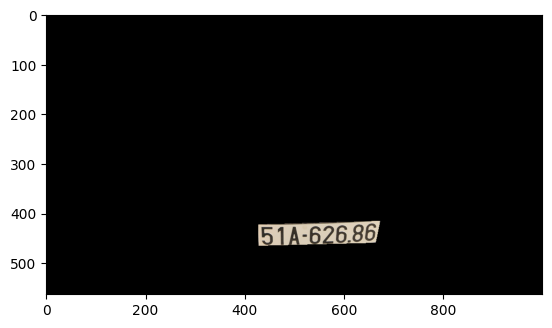

In [12]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location],0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

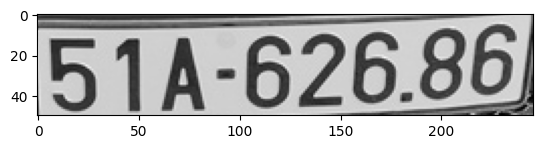

In [13]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
plate_image_n = gray[x1:x2+1, y1:y2+1]
plate_image = cv2.cvtColor(plate_image_n, cv2.COLOR_BGR2RGB)
plt.imshow(plate_image)

In [14]:
reader = easyocr.Reader(['en'])
result = reader.readtext(plate_image)
result

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\easyocr\detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.

[([[0, 0], [246, 0], [246, 50], [0, 50]], '51A-626.86)', 0.3952279718021729)]

In [15]:
char_library = {}
base_dir = "char_library"  # Đường dẫn tới thư viện ký tự
# Duyệt qua các thư mục con trong thư viện ký tự
for char_dir in os.listdir(base_dir):
    char_path = os.path.join(base_dir, char_dir)  # Đường dẫn tới từng thư mục con
    if os.path.isdir(char_path):  # Kiểm tra nếu đó là một thư mục
        for filename in os.listdir(char_path):  # Duyệt qua các file trong thư mục con
            if filename.endswith(".jpg"):  # Kiểm tra file có đuôi .jpg
                img = cv2.imread(os.path.join(char_path, filename), 0)  # Load ảnh mức xám
                char_library[char_dir] = img  # Gán ảnh vào từ điển với tên thư mục là ký tự

In [16]:
# Chuyển đổi biển số thành ảnh grayscale và nhị phân
gray_plate = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
_, binary_plate = cv2.threshold(gray_plate, 128, 255, cv2.THRESH_BINARY_INV)

# Tìm các contour của các ký tự
contours, _ = cv2.findContours(binary_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sắp xếp các contours từ trái sang phải
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

recognized_text = ""
characters = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Cắt từng ký tự
    char_image = binary_plate[y:y + h, x:x + w]
    characters.append(char_image)



# Hiển thị tất cả các ký tự đã cắt
# plt.figure(figsize=(10, 5))
# for i, char_image in enumerate(characters):
#     plt.subplot(1, len(characters), i + 1)  # Tạo lưới để hiển thị các ký tự
#     plt.imshow(char_image, cmap='gray')  # Hiển thị ảnh ký tự
#     plt.axis('off')  # Ẩn trục tọa độ
# plt.show()

#     # Tìm ký tự tương ứng từ thư viện
#     best_match = None
#     best_score = float('inf')
#     for char, template in char_library.items():
#         resized_char_img = cv2.resize(char_image, (template.shape[1], template.shape[0]))
#         score = np.sum((template - resized_char_img) ** 2)  # Tính độ lệch bình phương
#         if score < best_score:
#             best_score = score
#             best_match = char
        
#     recognized_text += best_match

# print("Biển số đã nhận diện:", recognized_text)